In [118]:
# Historical data from Stock Prices - Problems Day 0-365
import pandas as pd

# Load the Excel file to inspect its structure
file_path = 'Stock Prices - Days 0-365.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load the data from "Sheet1" into a pandas DataFrame
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Extract relevant columns for HydroCorp and BrightFuture
df_cleaned = df.iloc[1:, [1, 3, 4]]  # Selecting 'Day', 'HydroCorp', and 'BrightFuture' columns
df_cleaned.columns = ['Day', 'HydroCorp', 'BrightFuture']  # Renaming columns for clarity

# Convert data to appropriate types
df_cleaned['Day'] = pd.to_numeric(df_cleaned['Day'], errors='coerce')
df_cleaned['HydroCorp'] = pd.to_numeric(df_cleaned['HydroCorp'], errors='coerce')
df_cleaned['BrightFuture'] = pd.to_numeric(df_cleaned['BrightFuture'], errors='coerce')

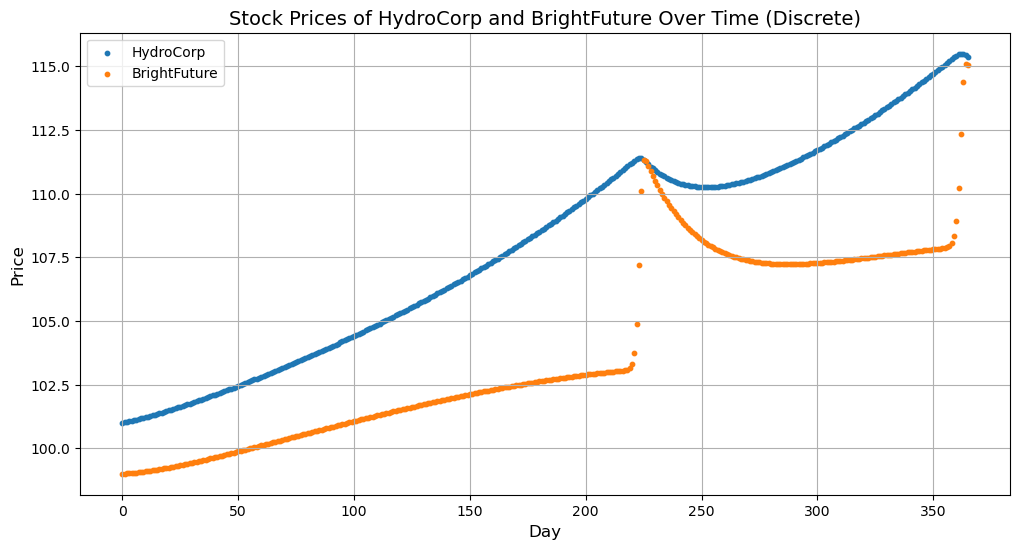

In [119]:
import matplotlib.pyplot as plt

# Re-plot the stock prices without smoothing (plotting data points directly)
plt.figure(figsize=(12, 6))
plt.scatter(df_cleaned['Day'], df_cleaned['HydroCorp'], label='HydroCorp', s=10)
plt.scatter(df_cleaned['Day'], df_cleaned['BrightFuture'], label='BrightFuture', s=10)

# Add titles and labels
plt.title('Stock Prices of HydroCorp and BrightFuture Over Time (Discrete)', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)

# Display the graph
plt.show()


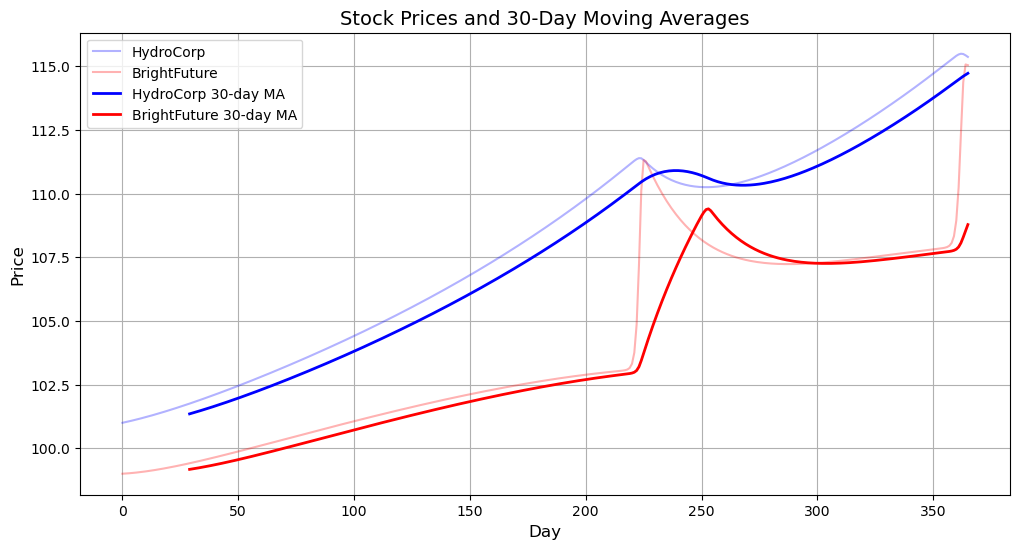

In [120]:
# Calculate 30-day moving averages for both stocks
window_size = 30
hydro_ma = df_cleaned['HydroCorp'].rolling(window=window_size).mean()
bright_ma = df_cleaned['BrightFuture'].rolling(window=window_size).mean()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot original prices
plt.plot(df_cleaned['Day'], df_cleaned['HydroCorp'], 'b-', alpha=0.3, label='HydroCorp')
plt.plot(df_cleaned['Day'], df_cleaned['BrightFuture'], 'r-', alpha=0.3, label='BrightFuture')

# Plot moving averages
plt.plot(df_cleaned['Day'], hydro_ma, 'b-', linewidth=2, label='HydroCorp 30-day MA')
plt.plot(df_cleaned['Day'], bright_ma, 'r-', linewidth=2, label='BrightFuture 30-day MA')

# Customize the plot
plt.title('Stock Prices and 30-Day Moving Averages', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)

plt.show()

In [121]:
# Define the exponential smoothing function
def exponential_smoothing(series, alpha = 0.5):
    """
    Apply exponential smoothing to a series.
    :param series: pandas Series to smooth
    :param alpha: Smoothing factor (0 < alpha <= 1)
    :return: pandas Series with smoothed values
    """
    smoothed = [series.iloc[0]]  # Initialize with the first value
    for t in range(1, len(series)):
        smoothed_value = alpha * series.iloc[t] + (1 - alpha) * smoothed[-1]
        smoothed.append(smoothed_value)
    return pd.Series(smoothed, index=series.index)

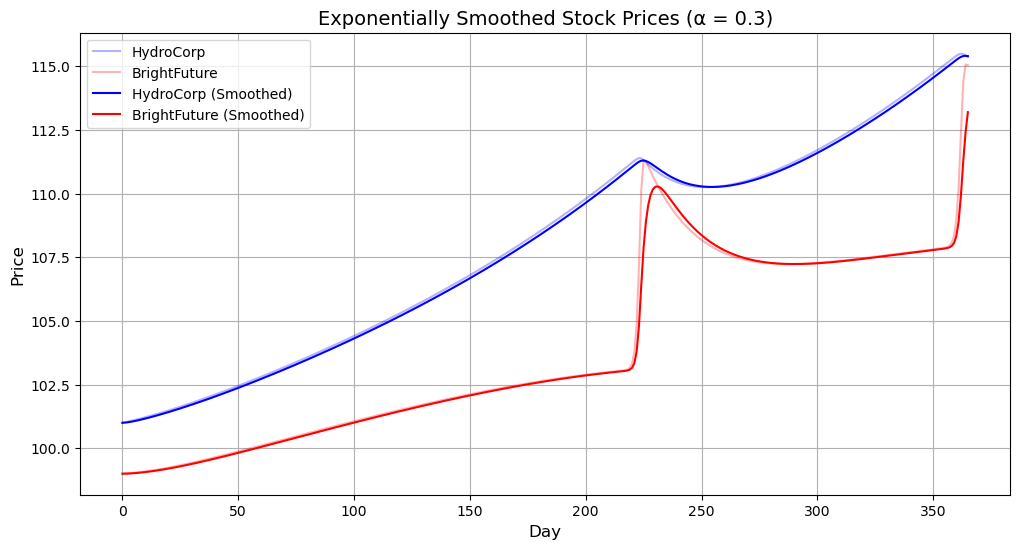

In [122]:
# Apply exponential smoothing to HydroCorp and BrightFuture with a chosen alpha
alpha = 0.3  # Smoothing factor
df_cleaned['HydroCorp_Smoothed'] = exponential_smoothing(df_cleaned['HydroCorp'], alpha)
df_cleaned['BrightFuture_Smoothed'] = exponential_smoothing(df_cleaned['BrightFuture'], alpha)

# Display the smoothed data
plt.figure(figsize=(12, 6))

# Plot original prices
plt.plot(df_cleaned['Day'], df_cleaned['HydroCorp'], 'b-', alpha=0.3, label='HydroCorp')
plt.plot(df_cleaned['Day'], df_cleaned['BrightFuture'], 'r-', alpha=0.3, label='BrightFuture')

# Plot original and smoothed data
plt.plot(df_cleaned['Day'], df_cleaned['HydroCorp_Smoothed'], 'b-', label='HydroCorp (Smoothed)')
plt.plot(df_cleaned['Day'], df_cleaned['BrightFuture_Smoothed'], 'r-', label='BrightFuture (Smoothed)')

plt.title('Exponentially Smoothed Stock Prices (α = ' + str(alpha) + ')', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)

plt.show()

In [123]:
# First remove the original price columns
df_cleaned = df_cleaned.drop(['HydroCorp', 'BrightFuture'], axis=1)

# Then rename the smoothed columns to be the price columns
df_cleaned = df_cleaned.rename(columns={
    'HydroCorp_Smoothed': 'HydroCorp',
    'BrightFuture_Smoothed': 'BrightFuture'
})

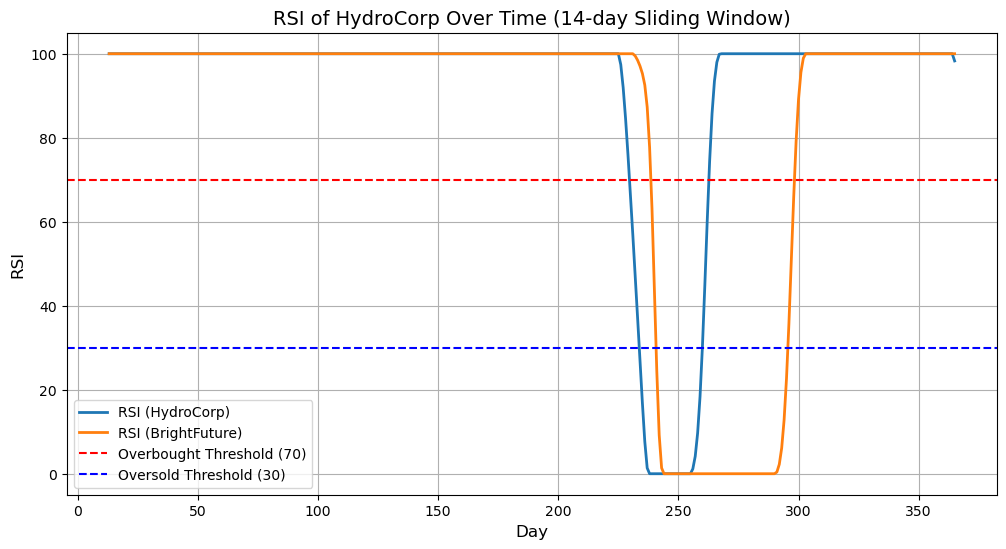

In [124]:
# Modified RSI function to calculate for every 14-day window
def calculate_rsi_sliding_window(series, periods=14):
    """
    Calculate the Relative Strength Index (RSI) for every 14-day sliding window using the formula:
    RSI = 100 - (100 / (1 + RS))
    RS = Average Gain / Average Loss

    Parameters:
    series (pd.Series): Price series data
    periods (int): Number of periods for the RSI calculation (default is 14)

    Returns:
    pd.Series: RSI values for each sliding window
    """
    rsi_values = []

    # Loop through the series, calculating RSI for each 14-day window
    for i in range(len(series) - periods + 1):
        window = series.iloc[i:i + periods]
        delta = window.diff()

        # Separate gains and losses
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        # Calculate average gain and average loss for the window
        avg_gain = gain.mean()
        avg_loss = loss.mean()

        # Avoid division by zero for RS calculation
        if avg_loss == 0:
            rsi = 100
        else:
            rs = avg_gain / avg_loss
            rsi = 100 - (100 / (1 + rs))

        rsi_values.append(rsi)

    # Prepend NaN values for the first `periods - 1` entries
    rsi_series = [None] * (periods - 1) + rsi_values

    return pd.Series(rsi_series, index=series.index)

# Example usage on a price series

# Apply RSI calculation to HydroCorp
df_cleaned['RSI_HydroCorp'] = calculate_rsi_sliding_window(df_cleaned['HydroCorp'], periods=14)
df_cleaned['RSI_BrightFuture'] = calculate_rsi_sliding_window(df_cleaned['BrightFuture'], periods=14)

# Plot the RSI values
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['Day'], df_cleaned['RSI_HydroCorp'], label='RSI (HydroCorp)', linewidth=2)
plt.plot(df_cleaned['Day'], df_cleaned['RSI_BrightFuture'], label='RSI (BrightFuture)', linewidth=2)
plt.axhline(70, color='red', linestyle='--', label='Overbought Threshold (70)')
plt.axhline(30, color='blue', linestyle='--', label='Oversold Threshold (30)')
plt.title('RSI of HydroCorp Over Time (14-day Sliding Window)', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('RSI', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


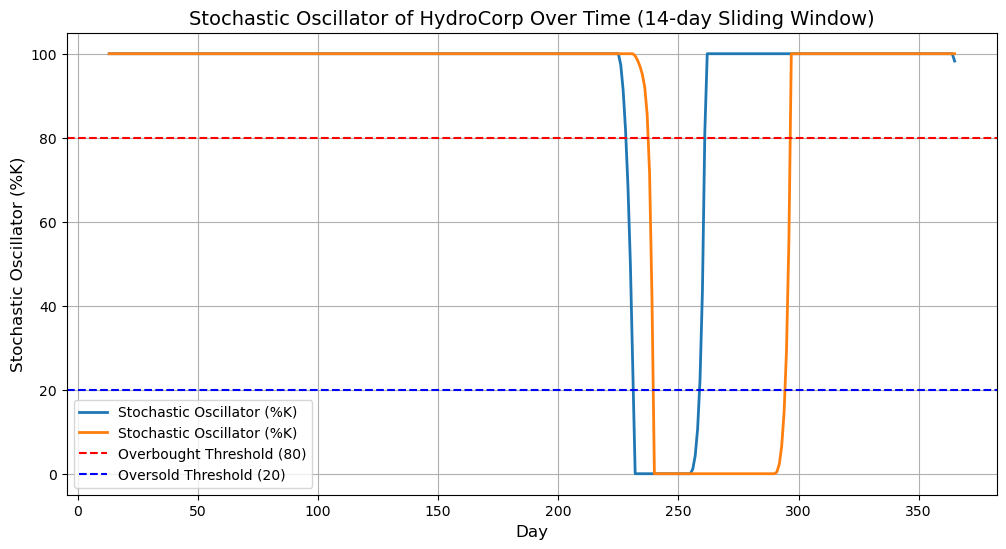

In [125]:
def calculate_stochastic_oscillator(series, periods=14):
    """
    Calculate the Stochastic Oscillator for a given price series over a sliding 14-day window.

    Formula:
    %K = ((Close - Lowest Low) / (Highest High - Lowest Low)) * 100

    Parameters:
    series (pd.Series): Price series data
    periods (int): Number of periods for the calculation (default is 14)

    Returns:
    pd.Series: Stochastic Oscillator (%K) values
    """
    stochastic_values = []

    # Loop through the series, calculating the oscillator for each 14-day window
    for i in range(len(series) - periods + 1):
        window = series.iloc[i:i + periods]
        highest_high = window.max()
        lowest_low = window.min()
        current_close = window.iloc[-1]

        # Calculate %K for the current window
        stochastic = ((current_close - lowest_low) / (highest_high - lowest_low)) * 100 if (highest_high - lowest_low) != 0 else None
        stochastic_values.append(stochastic)

    # Prepend NaN values for the first `periods - 1` entries
    stochastic_series = [None] * (periods - 1) + stochastic_values

    return pd.Series(stochastic_series, index=series.index)


# Example usage on a price series

# Apply Stochastic Oscillator calculation to HydroCorp
df_cleaned['Stochastic_HydroCorp'] = calculate_stochastic_oscillator(df_cleaned['HydroCorp'], periods=14)
df_cleaned['Stochastic_BrightFuture'] = calculate_stochastic_oscillator(df_cleaned['BrightFuture'], periods=14)

# Plot the Stochastic Oscillator values
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['Day'], df_cleaned['Stochastic_HydroCorp'], label='Stochastic Oscillator (%K)', linewidth=2)
plt.plot(df_cleaned['Day'], df_cleaned['Stochastic_BrightFuture'], label='Stochastic Oscillator (%K)', linewidth=2)
plt.axhline(80, color='red', linestyle='--', label='Overbought Threshold (80)')
plt.axhline(20, color='blue', linestyle='--', label='Oversold Threshold (20)')
plt.title('Stochastic Oscillator of HydroCorp Over Time (14-day Sliding Window)', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Stochastic Oscillator (%K)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


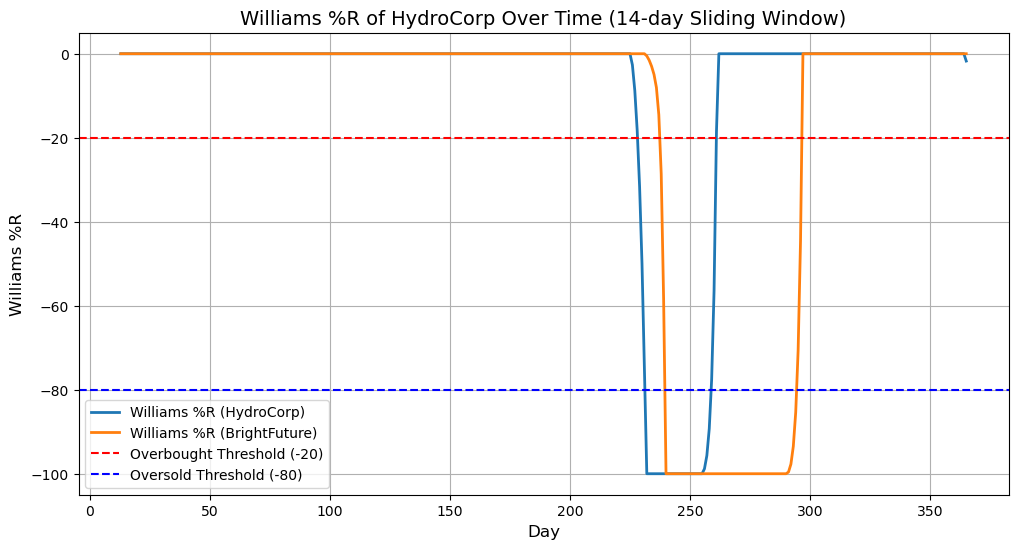

In [126]:
def calculate_williams_percent_r(series, periods=14):
    """
    Calculate the Williams %R for a given price series over a sliding 14-day window.

    Formula:
    %R = ((H14 - C) / (H14 - L14)) * -100

    Parameters:
    series (pd.Series): Price series data
    periods (int): Number of periods for the calculation (default is 14)

    Returns:
    pd.Series: Williams %R values
    """
    williams_values = []

    # Loop through the series, calculating %R for each 14-day window
    for i in range(len(series) - periods + 1):
        window = series.iloc[i:i + periods]
        highest_high = window.max()
        lowest_low = window.min()
        current_close = window.iloc[-1]

        # Calculate %R for the current window
        if (highest_high - lowest_low) != 0:
            williams_r = ((highest_high - current_close) / (highest_high - lowest_low)) * -100
        else:
            williams_r = None

        williams_values.append(williams_r)

    # Prepend NaN values for the first `periods - 1` entries
    williams_series = [None] * (periods - 1) + williams_values

    return pd.Series(williams_series, index=series.index)


# Apply Williams %R calculation to the same price series (e.g., HydroCorp)
df_cleaned['Williams_%R_HydroCorp'] = calculate_williams_percent_r(df_cleaned['HydroCorp'], periods=14)
df_cleaned['Williams_%R_BrightFuture'] = calculate_williams_percent_r(df_cleaned['BrightFuture'], periods=14)

# Plot the Williams %R values
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['Day'], df_cleaned['Williams_%R_HydroCorp'], label="Williams %R (HydroCorp)", linewidth=2)
plt.plot(df_cleaned['Day'], df_cleaned['Williams_%R_BrightFuture'], label="Williams %R (BrightFuture)", linewidth=2)
plt.axhline(-20, color='red', linestyle='--', label='Overbought Threshold (-20)')
plt.axhline(-80, color='blue', linestyle='--', label='Oversold Threshold (-80)')
plt.title("Williams %R of HydroCorp Over Time (14-day Sliding Window)", fontsize=14)
plt.xlabel("Day", fontsize=12)
plt.ylabel("Williams %R", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


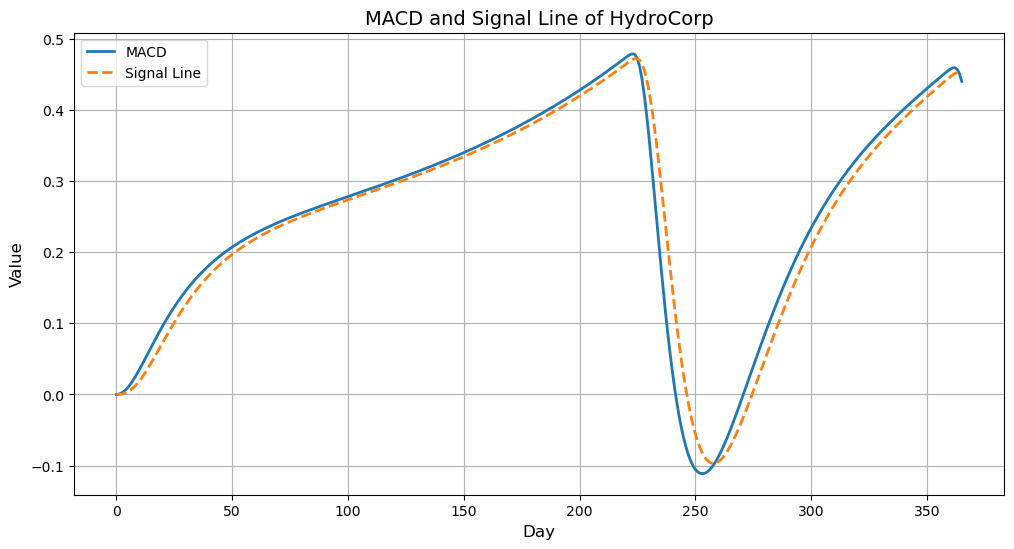

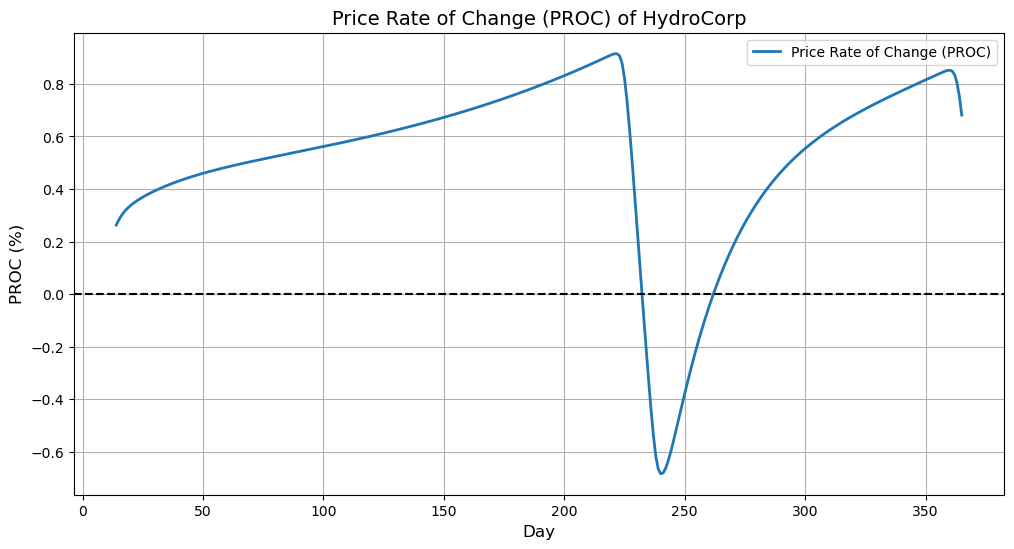

In [127]:
def calculate_macd(series, short_period=12, long_period=26, signal_period=9):
    """
    Calculate the Moving Average Convergence Divergence (MACD) and the Signal Line.

    Formula:
    MACD = EMA_12(C) - EMA_26(C)
    SignalLine = EMA_9(MACD)

    Parameters:
    series (pd.Series): Price series data
    short_period (int): Short EMA period (default is 12)
    long_period (int): Long EMA period (default is 26)
    signal_period (int): Signal Line EMA period (default is 9)

    Returns:
    pd.DataFrame: DataFrame containing MACD and Signal Line
    """
    ema_short = series.ewm(span=short_period, adjust=False).mean()
    ema_long = series.ewm(span=long_period, adjust=False).mean()
    macd = ema_short - ema_long
    signal_line = macd.ewm(span=signal_period, adjust=False).mean()

    return pd.DataFrame({'MACD': macd, 'SignalLine': signal_line})


def calculate_price_rate_of_change(series, periods=14):
    """
    Calculate the Price Rate of Change (PROC).

    Formula:
    PROC(t) = (C(t) - C(t-n)) / C(t-n) * 100

    Parameters:
    series (pd.Series): Price series data
    periods (int): Number of periods for the calculation (default is 14)

    Returns:
    pd.Series: Price Rate of Change values
    """
    proc = ((series - series.shift(periods)) / series.shift(periods)) * 100
    return proc


# Apply the MACD and PROC calculations
df_cleaned['MACD'] = calculate_macd(df_cleaned['HydroCorp'])['MACD']
df_cleaned['SignalLine'] = calculate_macd(df_cleaned['HydroCorp'])['SignalLine']
df_cleaned['PROC'] = calculate_price_rate_of_change(df_cleaned['HydroCorp'], periods=14)

# Plot the MACD and Signal Line
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['Day'], df_cleaned['MACD'], label='MACD', linewidth=2)
plt.plot(df_cleaned['Day'], df_cleaned['SignalLine'], label='Signal Line', linewidth=2, linestyle='--')
plt.title('MACD and Signal Line of HydroCorp', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Plot the Price Rate of Change
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['Day'], df_cleaned['PROC'], label='Price Rate of Change (PROC)', linewidth=2)
plt.axhline(0, color='black', linestyle='--')
plt.title('Price Rate of Change (PROC) of HydroCorp', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('PROC (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


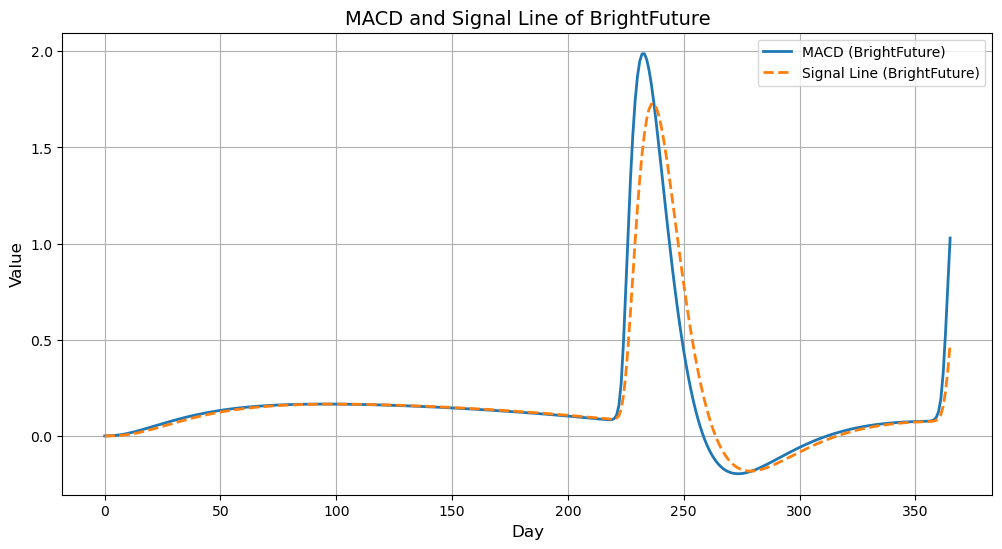

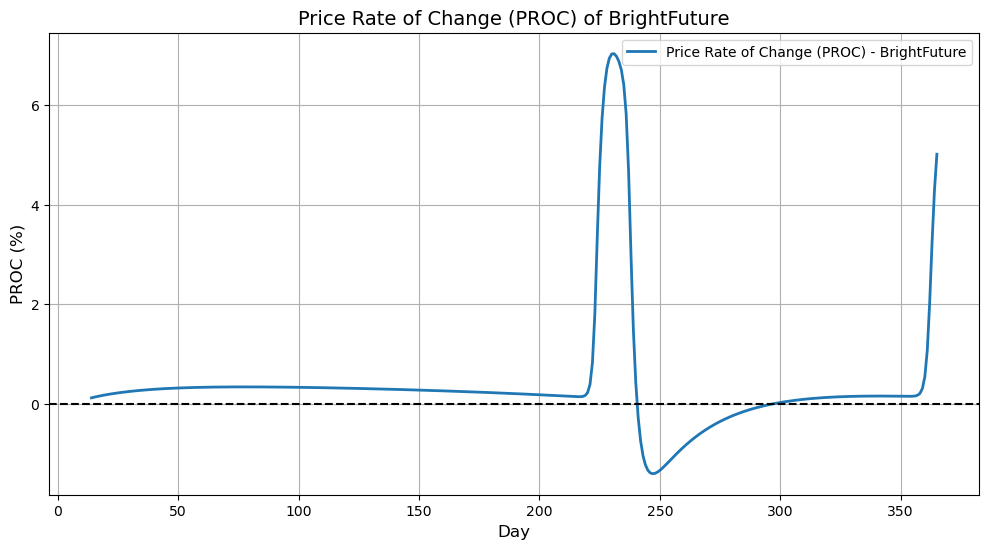

In [128]:
# Calculate MACD and Signal Line for BrightFuture
df_cleaned['MACD_BrightFuture'] = calculate_macd(df_cleaned['BrightFuture'])['MACD']
df_cleaned['SignalLine_BrightFuture'] = calculate_macd(df_cleaned['BrightFuture'])['SignalLine']

# Calculate Price Rate of Change (PROC) for BrightFuture
df_cleaned['PROC_BrightFuture'] = calculate_price_rate_of_change(df_cleaned['BrightFuture'], periods=14)

# Plot MACD and Signal Line for BrightFuture
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['Day'], df_cleaned['MACD_BrightFuture'], label='MACD (BrightFuture)', linewidth=2)
plt.plot(df_cleaned['Day'], df_cleaned['SignalLine_BrightFuture'], label='Signal Line (BrightFuture)', linewidth=2, linestyle='--')
plt.title('MACD and Signal Line of BrightFuture', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Plot the Price Rate of Change (PROC) for BrightFuture
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['Day'], df_cleaned['PROC_BrightFuture'], label='Price Rate of Change (PROC) - BrightFuture', linewidth=2)
plt.axhline(0, color='black', linestyle='--')
plt.title('Price Rate of Change (PROC) of BrightFuture', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('PROC (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [129]:
# Show all columns in df_cleaned
print("Columns in df_cleaned:")
for i, column in enumerate(df_cleaned.columns):
    print(f"{i+1}. {column}")

Columns in df_cleaned:
1. Day
2. HydroCorp
3. BrightFuture
4. RSI_HydroCorp
5. RSI_BrightFuture
6. Stochastic_HydroCorp
7. Stochastic_BrightFuture
8. Williams_%R_HydroCorp
9. Williams_%R_BrightFuture
10. MACD
11. SignalLine
12. PROC
13. MACD_BrightFuture
14. SignalLine_BrightFuture
15. PROC_BrightFuture


In [136]:
# Rename the columns to be more specific to HydroCorp
df_cleaned = df_cleaned.rename(columns={
    'MACD': 'MACD_HydroCorp',
    'PROC': 'PROC_HydroCorp',
    'SignalLine': 'SignalLine_HydroCorp',
    'BrightFuture': 'BrightFuture_Price',
    'HydroCorp' : 'HydroCorp_Price'
})

In [137]:
# Create direction indicators using a 14-day comparison
df_cleaned['Direction14_HydroCorp'] = (df_cleaned['HydroCorp_Price'] > df_cleaned['HydroCorp_Price'].shift(14)).astype(int) * 2 - 1
df_cleaned['Direction14_BrightFuture'] = (df_cleaned['BrightFuture_Price'] > df_cleaned['BrightFuture_Price'].shift(14)).astype(int) * 2 - 1

# First 14 days will be NaN since there's no data 14 days prior to compare with
df_cleaned.loc[:14, 'Direction14_HydroCorp'] = 0
df_cleaned.loc[:14, 'Direction14_BrightFuture'] = 0

In [138]:
# # Create direction indicators using diff() to compare with previous day
# df_cleaned['Direction_HydroCorp'] = (df_cleaned['Price_HydroCorp'].diff() > 0).astype(int) * 2 - 1
# df_cleaned['Direction_BrightFuture'] = (df_cleaned['BrightFuture_Price'].diff() > 0).astype(int) * 2 - 1

# # First day will be NaN since there's no previous day to compare with
# df_cleaned.loc[1, 'Direction_HydroCorp'] = 0
# df_cleaned.loc[1, 'Direction_BrightFuture'] = 0

In [139]:
# Show all columns in df_cleaned
print("Columns in df_cleaned:")
for i, column in enumerate(df_cleaned.columns):
    print(f"{i+1}. {column}")

Columns in df_cleaned:
1. Day
2. HydroCorp_Price
3. BrightFuture_Price
4. RSI_HydroCorp
5. RSI_BrightFuture
6. Stochastic_HydroCorp
7. Stochastic_BrightFuture
8. Williams_%R_HydroCorp
9. Williams_%R_BrightFuture
10. MACD_HydroCorp
11. SignalLine_HydroCorp
12. PROC_HydroCorp
13. MACD_BrightFuture
14. SignalLine_BrightFuture
15. PROC_BrightFuture
16. Direction14_HydroCorp
17. Direction14_BrightFuture


In [140]:
# Create separate DataFrames for each stock with all relevant indicators
hydro_columns = [col for col in df_cleaned.columns if 'HydroCorp' in col or col == 'Day']
bright_columns = [col for col in df_cleaned.columns if 'BrightFuture' in col or col == 'Day']

# Create DataFrames
hydro_df = df_cleaned[hydro_columns].copy()
bright_df = df_cleaned[bright_columns].copy()

# Drop any rows with NaN values since they can't be used for training
hydro_df = hydro_df.dropna()
bright_df = bright_df.dropna()

# Remove SignalLine columns
hydro_df = hydro_df.drop('SignalLine_HydroCorp', axis=1)
bright_df = bright_df.drop('SignalLine_BrightFuture', axis=1)

In [141]:
# Save to CSV
hydro_df.to_csv('hydrocorp_data.csv', index=False)
bright_df.to_csv('brightfuture_data.csv', index=False)

print("HydroCorp columns:")
print(hydro_df.columns.tolist())
print("\nBrightFuture columns:")
print(bright_df.columns.tolist())

HydroCorp columns:
['Day', 'HydroCorp_Price', 'RSI_HydroCorp', 'Stochastic_HydroCorp', 'Williams_%R_HydroCorp', 'MACD_HydroCorp', 'PROC_HydroCorp', 'Direction14_HydroCorp']

BrightFuture columns:
['Day', 'BrightFuture_Price', 'RSI_BrightFuture', 'Stochastic_BrightFuture', 'Williams_%R_BrightFuture', 'MACD_BrightFuture', 'PROC_BrightFuture', 'Direction14_BrightFuture']


In [142]:
# Get the last 26 days of data for both stocks
last_26_days = df_cleaned[['Day', 'HydroCorp_Price', 'BrightFuture_Price']].tail(26)

# Convert to numpy array for just the prices (excluding Day)
price_array = last_26_days[['HydroCorp_Price', 'BrightFuture_Price']].to_numpy()

print("Shape of price array:", price_array.shape)
print("\nLast 26 days of stock prices (HydroCorp, BrightFuture):")
print(price_array)

Shape of price array: (26, 2)

Last 26 days of stock prices (HydroCorp, BrightFuture):
[[113.88150027 107.67306205]
 [113.94673429 107.68465041]
 [114.01234296 107.69619525]
 [114.07832626 107.7076911 ]
 [114.14468428 107.71913269]
 [114.21141719 107.73051492]
 [114.27852528 107.74183302]
 [114.34600893 107.75308266]
 [114.4138686  107.76426057]
 [114.4821048  107.77536582]
 [114.55071808 107.78640325]
 [114.61970887 107.79739215]
 [114.68907723 107.80838817]
 [114.75882213 107.81953893]
 [114.82893966 107.83122522]
 [114.89941846 107.84441875]
 [114.97022823 107.86158671]
 [115.04129053 107.88896061]
 [115.11240546 107.94210629]
 [115.18306974 108.05883797]
 [115.25204346 108.32462121]
 [115.31642262 108.89846455]
 [115.37020996 109.93699042]
 [115.40437177 111.2686434 ]
 [115.41324595 112.41053954]
 [115.40059889 113.20069055]]


In [148]:
import numpy as np

# Extract HydroCorp and BrightFuture prices from the price array
hydro_prices = price_array[:, 0]  # First column contains HydroCorp prices
bright_prices = price_array[:, 1]  # Second column contains BrightFuture prices

# Print the arrays in a format that's easy to copy into code
print("hydro_prices = np.array([")
print(",".join([f"{x:.8f}" for x in hydro_prices]))
print("])\n")

print("bright_prices = np.array([")
print(",".join([f"{x:.8f}" for x in bright_prices]))
print("])")


hydro_prices = np.array([
113.88150027,113.94673429,114.01234296,114.07832626,114.14468428,114.21141719,114.27852528,114.34600893,114.41386860,114.48210480,114.55071808,114.61970887,114.68907723,114.75882213,114.82893966,114.89941846,114.97022823,115.04129053,115.11240546,115.18306974,115.25204346,115.31642262,115.37020996,115.40437177,115.41324595,115.40059889
])

bright_prices = np.array([
107.67306205,107.68465041,107.69619525,107.70769110,107.71913269,107.73051492,107.74183302,107.75308266,107.76426057,107.77536582,107.78640325,107.79739215,107.80838817,107.81953893,107.83122522,107.84441875,107.86158671,107.88896061,107.94210629,108.05883797,108.32462121,108.89846455,109.93699042,111.26864340,112.41053954,113.20069055
])
